In [1]:
import umap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from glow import Flow, Glow
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

In [2]:
split_dir = "../../../../assets/data/celeba"
# split_dir = "../../../../../../../../dgx1nas1/storage/data/jcaicedo/dsae/celebA"
# celeba_train = CelebaEmbedDataset(npy_path=, csv_path=f'{split_dir}/train_features.csv')
embed_train = np.load(f'{split_dir}/train_features.npy')
embed_valid = np.load(f'{split_dir}/val_features.npy')
embed_test  = np.load(f'{split_dir}/test_features.npy')

In [3]:
split_dir = "../../../../assets/data/celeba"
df_train = pd.read_csv(f'{split_dir}/train_features.csv')
df_valid = pd.read_csv(f'{split_dir}/val_features.csv')
df_test = pd.read_csv(f'{split_dir}/test_features.csv')

# Glow

In [4]:
import umap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

split_dir = "../../../../assets/data/celeba"
# split_dir = "../../../../../../../../dgx1nas1/storage/data/jcaicedo/dsae/celebA"
# celeba_train = CelebaEmbedDataset(npy_path=, csv_path=f'{split_dir}/train_features.csv')
embed_train = np.load(f'{split_dir}/train_features.npy')
embed_valid = np.load(f'{split_dir}/val_features.npy')
embed_test  = np.load(f'{split_dir}/test_features.npy')

from tqdm import tqdm
from math import log, sqrt, pi

def calc_loss(log_p, logdet, num_features, n_bins):
    # log_p = calc_log_p([z_list])

    loss = -log(n_bins) * num_features
    loss = loss + logdet + log_p

    return (
        (-loss / (log(2) * num_features)).mean(),
        (log_p / (log(2) * num_features)).mean(),
        (logdet / (log(2) * num_features)).mean(),
    )

def train(dataset, model, optimizer, epochs, lr, device):
    with tqdm(enumerate(iter(dataset))) as pbar:
        for i, embed in pbar:
            # embed = next(dataset)
            embed = embed.to(device)
            embed_size = embed.shape[1]
            embed = embed.reshape(-1, 384, 1, 1)

            # dequantization
            # log_p, logdet, _ = model(image + torch.rand_like(image) / n_bins)
            log_p, logdet, _ = model(embed)

            logdet = logdet.mean()

            loss, log_p, log_det = calc_loss(log_p, logdet, 384, 256)

            model.zero_grad()
            loss.backward()
            
            # warmup_lr = args.lr * min(1, i * batch_size / (50000 * 10))
            warmup_lr = lr
            optimizer.param_groups[0]["lr"] = warmup_lr
            optimizer.step()

            pbar.set_description(
                f"Loss: {loss.item():.5f}; logP: {log_p.item():.5f}; logdet: {log_det.item():.5f}; lr: {warmup_lr:.7f}"
            )


In [5]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(embed_train, batch_size=64, shuffle=True)

In [7]:
from glow import Flow, Glow
import torch
from torch import optim

n_flow = 32
n_block = 2
lr = 1e-4
epochs = 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Glow(
    384, n_flow, n_block, affine=True, conv_lu=True
).to(device)

Creating block
Creating block


In [8]:
version = f"_linear_{n_flow}_{n_block}_1e-4_{epochs}"
model_name = "model" + version
model.load_state_dict(torch.load(f"./{model_name}.pt"))

<All keys matched successfully>

In [9]:
train_z = np.load(f'./train_embed{version}.npy').squeeze()
valid_z = np.load(f'./valid_embed{version}.npy').squeeze()

In [151]:
train_z.shape

(162770, 384)

In [10]:
def generate_forward_embeddings(model, device, dataset, filename):
    dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

    model.eval()
    with torch.no_grad():
        embeds = []
        for embed in tqdm(dataloader):
            embed = torch.Tensor(embed).to(device)
            embed = embed.squeeze()
            log_p_sum, logdet, z_outs = model(embed)
            embeds.append(z_outs[0].cpu().numpy())
        embeds = np.concatenate(embeds)

    # save embeddings
    np.save(f"{filename}.npy", embeds)

In [11]:
def generate_reverse_embeddings(model, device, dataset, filename=None, reconstruct=True):
    dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

    model.eval()
    with torch.no_grad():
        embeds = []
        for z_embed in tqdm(dataloader):
            z_embed = torch.Tensor(z_embed).to(device)
            # print(z_embed.shape)
            dim_len = len(z_embed.shape)
            if dim_len < 3:
                z_embed = z_embed.unsqueeze(1)

            z_embed = torch.transpose(z_embed, 0, 1).unsqueeze(dim_len).unsqueeze(dim_len + 1)
            input = model.reverse(z_embed, reconstruct=reconstruct)
            embeds.append(input.cpu().numpy())
        embeds = np.concatenate(embeds)

    # save embeddings
    if filename:
        np.save(f"{filename}.npy", embeds)
    return embeds


In [12]:
train_dataloader = DataLoader(train_z, batch_size=64, shuffle=False)

In [136]:
z = next(iter(train_dataloader))
# 64, 2, 192
print(z.shape)
dim_len = len(z.shape)
# if dim_len < 3:
#     z = z.unsqueeze(0)
#     dim_len = len(z.shape)

z = z.unsqueeze(dim_len).unsqueeze(dim_len + 1).cuda()
if dim_len > 2:
    z = torch.transpose(z, 0, 1)
print(z.shape)
# torch.Size([2, 64, 192, 1, 1])

torch.Size([64, 2, 192])
torch.Size([2, 64, 192, 1, 1])


In [137]:
model.reverse(z).shape

/home/jupyter-aquach@broadinstit-9cd67/.local/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


torch.Size([64, 384, 1, 1])

In [14]:
train_recon = generate_reverse_embeddings(model, device, train_z, filename=f"./train_reconstruct{version}").reshape(-1, 384)
valid_recon = generate_reverse_embeddings(model, device, valid_z, filename=f"./valid_reconstruct{version}").reshape(-1, 384)

  0%|          | 0/2544 [00:00<?, ?it/s]/home/jupyter-aquach@broadinstit-9cd67/.local/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 312/312 [00:58<00:00,  5.33it/s]


In [155]:
train_recon.shape

(162770, 384)

In [13]:
train_recon = np.load(f'./train_reconstruct{version}.npy').reshape(-1, 384)
valid_recon = np.load(f'./valid_reconstruct{version}.npy').reshape(-1, 384)

FileNotFoundError: [Errno 2] No such file or directory: './train_reconstruct_linear_32_2_1e-4_1.npy'

In [15]:
recon_diff_train = train_recon - embed_train
print(recon_diff_train.shape)

(162770, 384)


In [16]:
recon_diff_valid = valid_recon - embed_valid
print(recon_diff_valid.shape)

(19961, 384)


# Visualize Glow UMAPS

reducer = umap.UMAP(random_state=42)
embedding_train = reducer.fit_transform(embed_train.data)
embedding_valid = reducer.tranasform(embed_valid.data)

In [17]:
reducer = umap.UMAP(random_state=42)
embedding_train = reducer.fit_transform(embed_train)

In [23]:
embedding_valid = reducer.transform(embed_valid)
embedding_valid_2 = embedding_valid[1:]

In [18]:
embedding_recon_train = reducer.transform(train_recon)

In [24]:
embedding_recon_valid = reducer.transform(valid_recon)
embedding_recon_valid_2 = embedding_recon_valid[1:]

In [20]:
print(version)
print("MSE Recon Diff Train: ", np.mean(np.square(recon_diff_train)))
print("MSE Recon Diff Valid: ", np.mean(np.square(recon_diff_valid)))

_linear_32_2_1e-4_1
MSE Recon Diff Train:  8.8890695e-10
MSE Recon Diff Valid:  8.8997776e-10


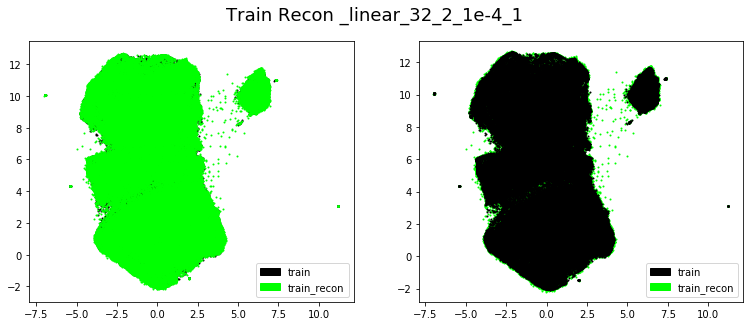

In [21]:
import matplotlib.patches as mpatches
colors = [[0, 0, 0], [0, 1, 0]]
descriptions = ["train", "train_recon"]
handles = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, descriptions)] 

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12.8, 4.8))

axs[0].scatter(embedding_train[:, 0], embedding_train[:, 1], c=[[0, 0, 0]], s=1)
axs[0].scatter(embedding_recon_train[:, 0], embedding_recon_train[:, 1], c=[[0, 1, 0]], s=1)
axs[0].legend(handles=handles)

axs[1].scatter(embedding_recon_train[:, 0], embedding_recon_train[:, 1], c=[[0, 1, 0]], s=1)
axs[1].scatter(embedding_train[:, 0], embedding_train[:, 1], c=[[0, 0, 0]], s=1)
axs[1].legend(handles=handles)

fig.gca().set_aspect('equal', 'datalim')
fig.suptitle(f'Train Recon {version}', fontsize=18)
fig.savefig(f'./train_recon_{version}.png', dpi=300)

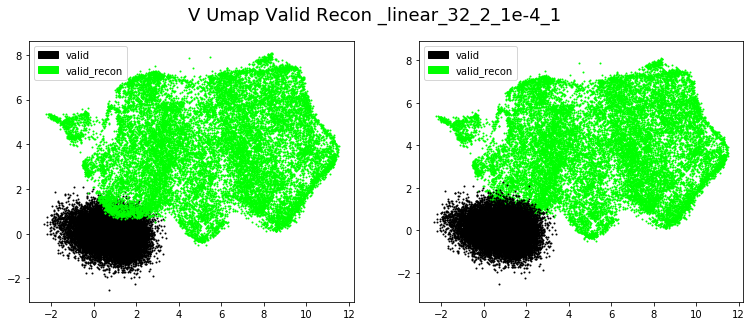

In [26]:
import matplotlib.patches as mpatches
colors = [[0, 0, 0], [0, 1, 0]]
descriptions = ["valid", "valid_recon"]
handles = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, descriptions)] 

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12.8, 4.8))

axs[0].scatter(embed_valid[:, 0], embed_valid[:, 1], c=[[0, 0, 0]], s=1)
axs[0].scatter(embedding_recon_valid_2[:, 0], embedding_recon_valid_2[:, 1], c=[[0, 1, 0]], s=1)
axs[0].legend(handles=handles)

axs[1].scatter(embedding_recon_valid_2[:, 0], embedding_recon_valid_2[:, 1], c=[[0, 1, 0]], s=1)
axs[1].scatter(embed_valid[:, 0], embed_valid[:, 1], c=[[0, 0, 0]], s=1)
axs[1].legend(handles=handles)

fig.gca().set_aspect('equal', 'datalim')
fig.suptitle(f'Valid Recon {version}', fontsize=18)
fig.savefig(f'./valid_recon_{version}.png', dpi=300)

# Compare Reconstructions

In [33]:
train_recon = generate_reverse_embeddings(model, device, train_z, filename="./train_reconstruct_base")

100%|██████████| 2544/2544 [04:32<00:00,  9.34it/s]


In [43]:
train_RECON = generate_reverse_embeddings(model, device, train_z, filename="./train_reconstruct_base", reconstruct=True)

  0%|          | 0/2544 [00:00<?, ?it/s]/home/jupyter-aquach@broadinstit-9cd67/.local/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 2544/2544 [04:30<00:00,  9.41it/s]


In [ ]:
valid_recon = generate_reverse_embeddings(model, device, valid_z, filename="./valid_reconstruct_base", reconstruct=True)

In [44]:
print(train_RECON.shape)
train_RECON = train_RECON.reshape(-1, 384)

(162770, 384, 1, 1)


In [40]:
recon_diff_train = train_recon - embed_train

In [42]:
recon_diff_train

array([[ 0.8497398 ,  1.0692667 ,  1.2081476 , ...,  0.05063711,
        -0.10026187, -1.2802    ],
       [-0.37564   ,  1.1924379 , -0.23998839, ..., -2.85033   ,
         0.00987417, -1.2447468 ],
       [-0.52633035, -0.97676903,  1.2021434 , ...,  0.14163399,
        -0.6845984 ,  0.25906962],
       ...,
       [ 0.4264586 ,  1.0939007 ,  0.26949805, ..., -1.3599601 ,
         0.6405831 ,  0.728317  ],
       [-1.7399176 , -0.13010865, -1.2239674 , ...,  1.3062277 ,
         0.04344726, -0.22341514],
       [ 0.3694286 ,  0.18484718,  0.8002959 , ...,  0.30695856,
         0.07157296,  3.9659097 ]], dtype=float32)

In [45]:
recon_diff_train_corrected = train_RECON - embed_train
print(recon_diff_train_corrected)

[[ 0.8497398   1.0692667   1.2081476  ...  0.05063711 -0.10026187
  -1.2802    ]
 [-0.37564     1.1924379  -0.23998839 ... -2.85033     0.00987417
  -1.2447468 ]
 [-0.52633035 -0.97676903  1.2021434  ...  0.14163399 -0.6845984
   0.25906962]
 ...
 [ 0.4264586   1.0939007   0.26949805 ... -1.3599601   0.6405831
   0.728317  ]
 [-1.7399176  -0.13010865 -1.2239674  ...  1.3062277   0.04344726
  -0.22341514]
 [ 0.3694286   0.18484718  0.8002959  ...  0.30695856  0.07157296
   3.9659097 ]]


In [67]:
np.mean(np.square(recon_diff_train_corrected))

1.9314641

In [69]:
np.mean(np.square(train_RECON))

0.956019

In [68]:
np.mean(np.square(embed_train))

0.97160345

In [47]:
embedding_recon_train = reducer.transform(recon_diff_train)
embedding_recon_train_corrected = reducer.transform(recon_diff_train_corrected)

Text(0.5, 1.0, 'UMAP for original and reconstructions')

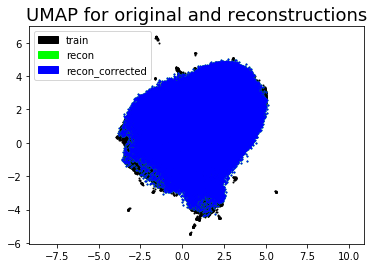

In [48]:
colors = [[0, 0, 0], [0, 1, 0], [0, 0, 1]]
descriptions = ["train", "recon", "recon_corrected"]

plt.scatter(embedding_train[:, 0], embedding_train[:, 1], c=[[0, 0, 0]], s=1)
plt.scatter(embedding_recon_train[:, 0], embedding_recon_train[:, 1], c=[[0, 1, 0]], s=1)
plt.scatter(embedding_recon_train_corrected[:, 0], embedding_recon_train_corrected[:, 1], c=[[0, 0, 1]], s=1)
plt.gca().set_aspect('equal', 'datalim')

import matplotlib.patches as mpatches
handles = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, descriptions)] 
plt.legend(handles=handles)
plt.title('UMAP for original and reconstructions', fontsize=18)

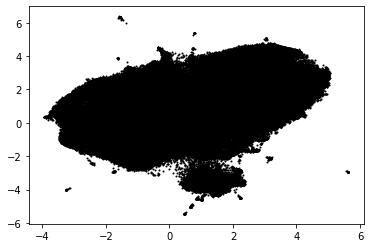

In [51]:
plt.scatter(embedding_train[:, 0], embedding_train[:, 1], c=[[0, 0, 0]], s=1)

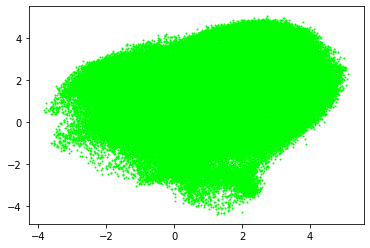

In [71]:
plt.scatter(embedding_recon_train[:, 0], embedding_recon_train[:, 1], c=[[0, 1, 0]], s=1)
# plt.scatter(train_z[:, 0], train_z[:, 1], c=[[1, 0, 0]], s=1)

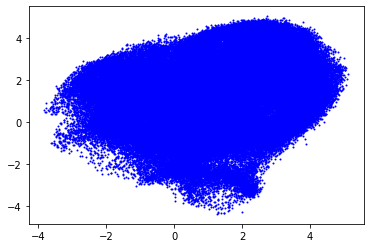

In [53]:
plt.scatter(embedding_recon_train_corrected[:, 0], embedding_recon_train_corrected[:, 1], c=[[0, 0, 1]], s=1)